<a href="https://colab.research.google.com/github/kalyani-m-g/CODSOFT/blob/main/task1_kalyani_m_g.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
!pip install -q kagglehub transformers datasets accelerate torch


In [79]:
import kagglehub
import os
import pandas as pd
import numpy as np
import torch


In [80]:
path = kagglehub.dataset_download("hijest/genre-classification-dataset-imdb")
print("Dataset path:", path)


Using Colab cache for faster access to the 'genre-classification-dataset-imdb' dataset.
Dataset path: /kaggle/input/genre-classification-dataset-imdb


In [81]:
os.listdir(path)


['Genre Classification Dataset']

In [82]:
data_dir = os.path.join(path, "Genre Classification Dataset")
os.listdir(data_dir)


['description.txt',
 'test_data_solution.txt',
 'test_data.txt',
 'train_data.txt']

In [83]:
train_file = os.path.join(data_dir, "train_data.txt")

df = pd.read_csv(
    train_file,
    sep=" ::: ",
    engine="python",
    names=["id", "title", "genre", "plot"]
)

df.head()


,id,title,genre,plot
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [84]:
print(df.shape)
print(df.isnull().sum())


(54214, 4)
id       0
title    0
genre    0
plot     0
dtype: int64


In [85]:
df["genre"].value_counts().head(10)


,count
genre,
drama,13613
documentary,13096
comedy,7447
short,5073
horror,2204
thriller,1591
action,1315
western,1032
reality-tv,884


In [86]:
genre_counts = df["genre"].value_counts()
valid_genres = genre_counts[genre_counts >= 100].index

df = df[df["genre"].isin(valid_genres)]

print("Remaining samples:", len(df))
print("Remaining genres:", df["genre"].nunique())


Remaining samples: 54214
Remaining genres: 27


In [87]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["genre"])

num_labels = df["label"].nunique()
print("Number of labels:", num_labels)


Number of labels: 27


In [88]:
df_small = df.sample(n=10000, random_state=42)

train_df, val_df = train_test_split(
    df_small,
    test_size=0.2,
    random_state=42,
    stratify=df_small["label"]
)


In [89]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(
    train_df[["plot", "label"]]
)

val_dataset = Dataset.from_pandas(
    val_df[["plot", "label"]]
)


In [90]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [91]:
def tokenize(batch):
    return tokenizer(
        batch["plot"],
        padding="max_length",
        truncation=True,
        max_length=256
    )


In [92]:
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [93]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [94]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",              #  stop saving checkpoints
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=200,
    report_to="none"
)



In [95]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)


/tmp/ipython-input-1652196004.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [96]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,2.049800,1.626889
2,1.519900,1.508449


TrainOutput(global_step=500, training_loss=1.714804412841797, metrics={'train_runtime': 110.1807, 'train_samples_per_second': 145.216, 'train_steps_per_second': 4.538, 'total_flos': 1060211662848000.0, 'train_loss': 1.714804412841797, 'epoch': 2.0})

In [97]:
trainer.evaluate()


{'eval_loss': 1.5084494352340698,
 'eval_runtime': 4.1739,
 'eval_samples_per_second': 479.174,
 'eval_steps_per_second': 15.094,
 'epoch': 2.0}

In [98]:
preds = trainer.predict(val_dataset)

y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

from sklearn.metrics import classification_report
print(classification_report(
    y_true,
    y_pred,
    target_names=label_encoder.classes_,
    zero_division=0
))


              precision    recall  f1-score   support

      action       0.42      0.31      0.35        49
       adult       0.00      0.00      0.00        21
   adventure       0.00      0.00      0.00        26
   animation       0.00      0.00      0.00        19
   biography       0.00      0.00      0.00        12
      comedy       0.54      0.57      0.56       266
       crime       0.00      0.00      0.00        20
 documentary       0.75      0.86      0.80       490
       drama       0.56      0.83      0.67       492
      family       0.00      0.00      0.00        27
     fantasy       0.00      0.00      0.00        14
   game-show       0.00      0.00      0.00         7
     history       0.00      0.00      0.00         8
      horror       0.36      0.72      0.48        78
       music       0.75      0.22      0.34        27
     musical       0.00      0.00      0.00         9
     mystery       0.00      0.00      0.00        10
        news       0.00    

In [99]:
model.save_pretrained("bert_genre_model")
tokenizer.save_pretrained("bert_genre_model")


('bert_genre_model/tokenizer_config.json',
 'bert_genre_model/special_tokens_map.json',
 'bert_genre_model/vocab.txt',
 'bert_genre_model/added_tokens.json',
 'bert_genre_model/tokenizer.json')

In [100]:
def predict(plot):
    device = model.device

    inputs = tokenizer(
        plot,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    )

    # 🔥 MOVE INPUTS TO MODEL DEVICE
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    pred_id = torch.argmax(outputs.logits, dim=1).item()
    return label_encoder.inverse_transform([pred_id])[0]



In [101]:
print(model.device)


cuda:0


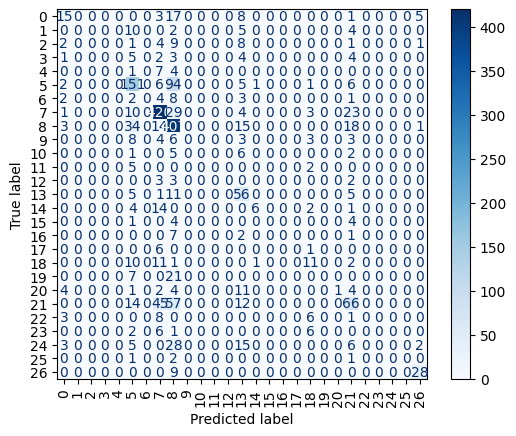

In [102]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    xticks_rotation=90,
    cmap="Blues"
)
plt.show()


In [ ]:
# -------- USER INPUT --------
user_plot = input("Enter movie plot summary:\n")

predicted_genre = predict(user_plot)

print("\nPredicted Genre:", predicted_genre)

